In [2]:
import numpy as np
import pandas as pd
import re
from collections import Counter
from scipy import special
import matplotlib.pyplot as plt
%matplotlib inline
import random
import cProfile

In [3]:
data = pd.read_csv('../../data/sherlock_current_wtext_samemonth.csv')

In [5]:
def preprocess(df):
    #pre-processing
    #input: a slice of the original df
    #output: a list of lists each containing cleaned words from a work
    df = df.astype(str)
    df = df.groupby('Author')['Text'].apply(','.join).reset_index()
    text = df[['Text']]
    text['Text'] = text['Text'].str.replace('A', '')
    text = text.drop_duplicates().Text.str.lower().str.split()
    text_cleaned = []
    for line in text:
        line = [re.sub(r'[^A-Za-z0-9]+', '', str(word)) for word in line]
        line = [word for word in line if len(word) > 1 and not word.isdigit()]
        text_cleaned.append(line)
    return text_cleaned

In [6]:
def filter_length(text, word_limit):
    return [line for line in text if len(line) > word_limit]

In [7]:
def filter_top_words(text, top_number):
    corpus = [word for line in text for word in line]
    c = Counter(corpus)
    top = [i[0] for i in c.most_common(top_number)]
    text_intop = []
    for line in text:
        line = [word for word in line if word in top]
        text_intop.append(line)
    return text_intop

In [8]:
def calculate_prob_matrix(text_list):
    #vectorize the words and turn each work into a list of word frequences over the whole vocalburary.
    #input: a list of list of words.
    #output: np array.
    vocabulary = list(set([word for text in text_list for word in text]))
    text_prob_matrix = []
    for text in text_list:
        freq_list = []
        c = Counter(text)
        for word in vocabulary:
            if word in text:
                freq_list.append(c[word])
            else:
                freq_list.append(0)
        s = float(sum(freq_list))
        if s != 0:
            text_prob = [freq/s for freq in freq_list]
            text_prob_matrix.append(text_prob)
    text_prob_matrix = np.asarray(text_prob_matrix)
    return text_prob_matrix

In [9]:
def JSD(P, Q):
    M = 0.5 * (P + Q)
    return 0.5 * (sum(special.rel_entr(P, M)) + sum(special.rel_entr(Q, M)))

In [10]:
def calculate_monthly_jsd(matrix):
    jsds = []
    for i in range(matrix.shape[0]):
        for j in range(i+1, matrix.shape[0]):
            jsds.append(JSD(matrix[i], matrix[j]))
    return jsds

In [11]:
def calculate_monthly_jsd_sampled(matrix):
    jsds = []
    l = matrix.shape[0]
    for n in range(1000):
        i = random.randrange(1, l)
        j = random.randrange(1, l)
        jsds.append(JSD(matrix[i], matrix[j]))
    return jsds

In [12]:
def bootstrap_resample(jsd_list):
    ave_original = np.average(jsd_list)
    aves = []
    for i in range(10000):
        sample = []
        for i in range(len(jsd_list)):
            sample.append(random.choice(jsd_list))
        aves.append(np.average(sample))
    tail = sorted(aves)[249]
    head = sorted(aves)[9750]
    return (ave_original, tail, head)

In [13]:
def create_df_time(df, time):
    return df[df.PublishDate.str[:7] == time]

In [37]:
def calculate_overall_jsd():
    jsds_timerange = []
    work_count = []
    for month in timelist:
        df_ts = create_df_time(data, month)
        text = preprocess(df_ts)
        text = filter_length(text, 500)
        work_count.append(len(text))
        text = filter_top_words(text, 1000)
        
        matrix = calculate_prob_matrix(text)
        monthly_jsds = calculate_monthly_jsd(matrix)
        monthly_ave_resampled_jsds = bootstrap_resample(monthly_jsds)
        jsds_timerange.append(monthly_ave_resampled_jsds)
        print "Finished calculation for: ", month, 'jsd = ', monthly_ave_resampled_jsds#, 'number of work:', len(text)
    return jsds_timerange, work_count


In [38]:
timelist = data.PublishDate.drop_duplicates().tolist()
timelist = [str(i)[:7] for i in timelist]
timelist = sorted(list(set(timelist)))

In [39]:
jsd, work_count = calculate_overall_jsd()

Finished calculation for:  2010-08 jsd =  (0.14846748489396683, 0.12227556215653983, 0.17629535349521488)
Finished calculation for:  2010-09 jsd =  (0.17738965072929838, 0.11733260184692214, 0.2278135135333812)
Finished calculation for:  2010-10 jsd =  (0.2048708022992439, 0.19407271994066688, 0.21690456565492977)
Finished calculation for:  2010-11 jsd =  (0.079773664482008108, 0.067556232739464053, 0.093096311783046726)
Finished calculation for:  2010-12 jsd =  (0.14294774607847216, 0.1153811571361304, 0.16892787727597738)
Finished calculation for:  2011-01 jsd =  (0.09957753417544786, 0.094514723304049628, 0.10467469874152203)
Finished calculation for:  2011-02 jsd =  (0.097905182839244903, 0.08969374592445184, 0.1060386164643928)
Finished calculation for:  2011-03 jsd =  (0.096973518101995199, 0.09093708311823645, 0.10304186631526568)
Finished calculation for:  2011-04 jsd =  (0.17340887627499338, 0.15734905701047, 0.18959839954679239)
Finished calculation for:  2011-05 jsd =  (0.12

/Users/jingy/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


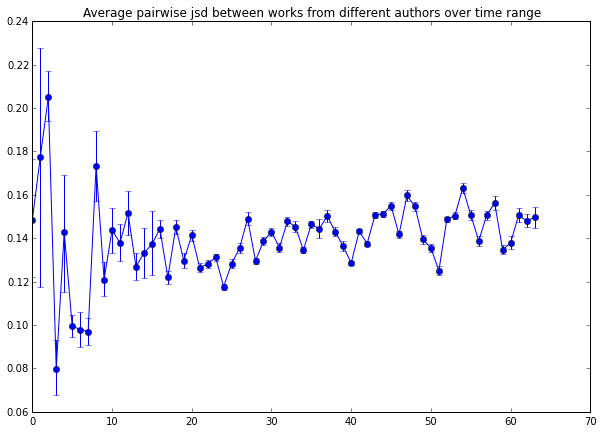

In [42]:
y = [i[0] for i in jsd]
x = range(len(y))

# example error bar values that vary with x-position
# error = 0.1 + 0.2 * x

# error bar values w/ different -/+ errors
lower_error = [i[0]-i[1] for i in jsd]
upper_error = [i[2]-i[0] for i in jsd]
asymmetric_error = [lower_error, upper_error]

fig, ax = plt.subplots(figsize = (10, 7))

ax.errorbar(x, y, yerr=asymmetric_error,marker='o')
ax.set_title('Average pairwise jsd between works from different authors over time range')
# ax.set_yscale('log')
# ax.set_ylim([0.180, 0.225])
plt.show()